<a href="https://colab.research.google.com/github/Osakana7777777/GNN_seminar/blob/main/gnn_cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNNの実装例

最終更新：2024/7/21


## GCN(Graph Convolutional Network)の実装例

Coraデータセットを3層のGCN（+線形層）で解く

T4 GPUを使用

In [1]:
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-qrcgrjy4
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-qrcgrjy4
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 00c45648fe3a7fdb23d2697c89b3f7403a10139e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.6.0-py3-none-any.whl size=1124898 sha256=2156ea3efff6a06f5b510c020b1c87a41e6187463599e1e02a486811b0422bf9
  Stored in directory: /tmp/pip-ephem-wheel-cache-t4wwuxkq/wheels/d3/78/eb/9e26525b948d19533f1688fb6c209cec8a0ba793d39b49ae8f
Successfully built torch-geometric


In [2]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(torch.cuda.get_device_name())
print(device)

Tesla T4
cuda


In [3]:
from torch_geometric.datasets import KarateClub, Planetoid
dataset = Planetoid(root="./", name="Cora")

Processing...
Done!


In [35]:
data = dataset[0]

In [39]:
print(f"クラス数:{dataset.num_classes}")
print(f"ノード数:{data.num_nodes}")
print(f"ノード特徴量:{dataset.num_node_features}")

クラス数:7
ノード数:2708
ノード特徴量:1433


In [42]:
# trainとtestに分かれている
print(sum(data.train_mask==True))
print(sum(data.val_mask==True))
print(sum(data.test_mask==True))

tensor(140)
tensor(500)
tensor(1000)


GCNは通常のNNとほぼ同様に書ける．（nn.Moduleを継承する）

順伝播でGCN layerに通すとき，グラフのノードとエッジの情報を取得しなければならないのが違い

In [163]:
# GCN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, use_mlp_layer=False):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 512) #
        self.conv2 = GCNConv(512, dataset.num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.use_mlp_layer = use_mlp_layer
        self.mlp = nn.Sequential(
            nn.Linear(dataset.num_classes, dataset.num_classes),
            nn.ReLU(),
            nn.Linear(dataset.num_classes, dataset.num_classes)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index # ノードとエッジの情報を取得
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        #x = self.relu(x)
        #x = self.dropout(x)
        #x = self.conv3(x, edge_index)
        if self.use_mlp_layer:
            x = self.relu(x)
            x = self.dropout(x)
            x = self.mlp(x)
            return x
        else:
            return x


In [164]:
model = GCN(use_mlp_layer=False).to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()
def eval():
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = criterion(out[data.test_mask], data.y[data.test_mask])
    return loss.item()



In [165]:
from tqdm.auto import tqdm
losses_tr = []
losses_te = []
epochs = 200
for epoch in tqdm(range(epochs), total=epochs):
    loss_tr = train()
    loss_te = eval()
    losses_tr.append(loss_tr)
    losses_te.append(loss_te)
    # print(f"epoch: {epoch}, loss_tr: {loss_tr}, loss_te: {loss_te}")

  0%|          | 0/200 [00:00<?, ?it/s]

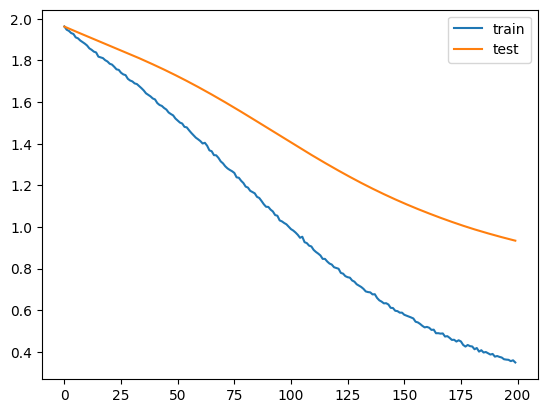

In [166]:
import matplotlib.pyplot as plt
plt.plot(losses_tr, label="train")
plt.plot(losses_te, label="test")
plt.legend()
plt.show()

In [167]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8030


## GAT

In [168]:
# GCN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, use_mlp_layer=False):
        super(GAT, self).__init__()
        self.conv1 = GATConv(dataset.num_node_features, 512) #
        self.conv2 = GATConv(512, dataset.num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.use_mlp_layer = use_mlp_layer
        self.mlp = nn.Sequential(
            nn.Linear(dataset.num_classes, dataset.num_classes),
            nn.ReLU(),
            nn.Linear(dataset.num_classes, dataset.num_classes)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index # ノードとエッジの情報を取得
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        #x = self.relu(x)
        #x = self.dropout(x)
        #x = self.conv3(x, edge_index)
        if self.use_mlp_layer:
            x = self.relu(x)
            x = self.dropout(x)
            x = self.mlp(x)
            return x
        else:
            return x


In [169]:
model = GAT(use_mlp_layer=False).to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()
def eval():
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = criterion(out[data.test_mask], data.y[data.test_mask])
    return loss.item()

In [170]:
from tqdm.auto import tqdm
losses_tr = []
losses_te = []
epochs = 200
for epoch in tqdm(range(epochs), total=epochs):
    loss_tr = train()
    loss_te = eval()
    losses_tr.append(loss_tr)
    losses_te.append(loss_te)
    # print(f"epoch: {epoch}, loss_tr: {loss_tr}, loss_te: {loss_te}")

  0%|          | 0/200 [00:00<?, ?it/s]

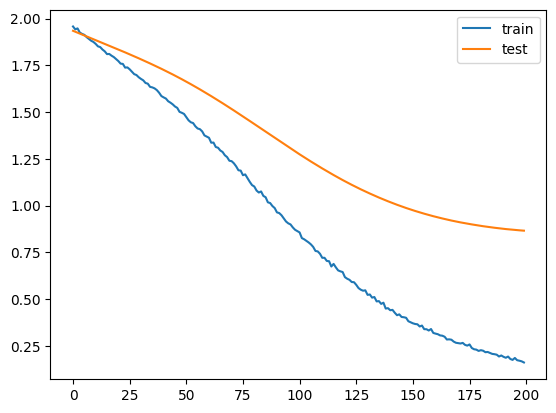

In [171]:
import matplotlib.pyplot as plt
plt.plot(losses_tr, label="train")
plt.plot(losses_te, label="test")
plt.legend()
plt.show()

In [172]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7730
